In [111]:
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

import os
import json

In [181]:
with open("data/train_set.json") as f:
    train_ids=json.load(f)

with open("data/test_set.json") as f:
    test_ids=json.load(f)


In [148]:
def read_images(image_id, plot=False):
    image_name=f"image_{image_id:04}.jpg"
    img=PIL.Image.open(f"data/jpg/{image_name}")
    img=np.array(img)

    sgm_name=f"image_{image_id:04}.png"
    sgm=PIL.Image.open(f"data/segmentations/{sgm_name}")
    sgm=np.array(sgm,dtype=np.int0)
    sgm=np.expand_dims(sgm, axis=2)
    #cropped_img=tf.image.random_crop(tf.concat([img,tf.expand_dims(sgm,axis=2)],axis=2), [120,120,4])

    if plot:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(img)
        ax[1].imshow(sgm)
        # ax[0].imshow(cropped_img[...,:3])
        # ax[1].imshow(cropped_img[...,3:])

    return img, sgm

def preprocess_images(img, sgm, shape):
    resized_img=tf.image.resize(img,shape)/255.
    resized_sgm=tf.image.resize(sgm,shape)/255.
    return resized_img, resized_sgm


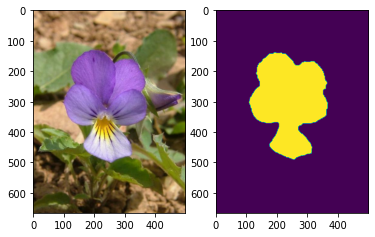

In [153]:
img,sgm=read_images(1334,plot=True)

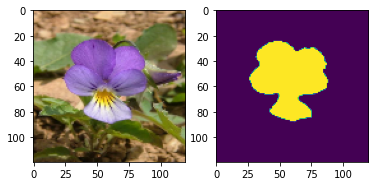

In [154]:
r_img,r_sgm=preprocess_images(img,sgm,(120,120))
fig, ax = plt.subplots(1,2)
ax[0].imshow(r_img)
ax[1].imshow(r_sgm)

In [182]:
def get_dataset(subset, shape=(120,120)):
    X=[]
    y=[]

    for img_id in subset:
        img,sgm=read_images(img_id)
        proc_img, proc_sgm=preprocess_images(img,sgm,shape)
        X.append(proc_img)
        y.append(proc_sgm)

    ds=tf.data.Dataset.from_tensor_slices((X,y))
    return ds


In [183]:
ds_train=get_dataset(train_ids)
ds_test=get_dataset(test_ids)

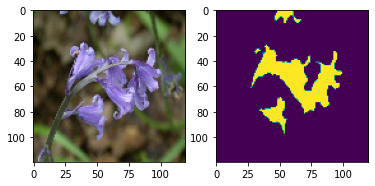

In [187]:
for ex in ds_train.take(1):
    ex

fig, ax = plt.subplots(1,2)
ax[0].imshow(ex[0])
ax[1].imshow(ex[1])

In [190]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras import Model

In [191]:
IMG_HEIGHT, IMG_WIDTH = (120,120)
def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'
            }

    metrics = {'seg': ['acc']
                }
    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model